# Loading Model and Testing

In [1]:
import sys
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline

from Base_transformer import TransformerPredictor 
from play_loader import load_play

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)
from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories,)     # <-- the file we made

In [2]:
# import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

# # 1) Define your loss exactly as before
# NUM_PLAYERS = 23
# PRED_LEN     = 40
# def euclidean_distance_loss(y_true, y_pred,
#                             pred_len=PRED_LEN,
#                             num_players=NUM_PLAYERS):
#     diff            = K.reshape(y_pred - y_true,
#                                 (-1, pred_len, num_players, 2))
#     sq_diff         = K.square(diff)
#     sum_sq_coords   = K.sum(sq_diff, axis=-1)
#     dist_pp         = K.sqrt(sum_sq_coords + 1e-6)
#     mean_per_frame  = K.mean(dist_pp, axis=-1)
#     mean_per_sample = K.mean(mean_per_frame, axis=-1)
#     return K.mean(mean_per_sample)

# # 2) Enable “unsafe” so we can load those Lambdas
# from tensorflow.keras import config
# config.enable_unsafe_deserialization()

# # 3) Load the old model (just to extract weights)
# orig = keras.models.load_model(
#     "../saved_models/lstm_att40f_best.keras",
#     compile=False,
#     custom_objects={"euclidean_distance_loss": euclidean_distance_loss}
# )

# # If you still have anonymous Lambdas that refer to tf/K, inject them:
# for L in orig.layers:
#     if isinstance(L, keras.layers.Lambda):
#         globs = L.function.__globals__
#         globs["tf"] = tf
#         globs["K"]  = K

# # 4) Save only the weights
# orig.save_weights("lstm_att40f.weights.h5")



In [3]:
# Hyper-parameters
LSTM_UNITS = 300
MAX_LEN = 100
NUM_PLAYERS = 23
NUM_FEATS = 2 * NUM_PLAYERS
PRED_LEN = 40

# Loss: mean Euclidean distance per player per frame
def euclidean_distance_loss(y_true, y_pred, pred_len=PRED_LEN, num_players=NUM_PLAYERS):
    # reshape to (batch, pred_len, players, coords)
    diff = K.reshape(y_pred - y_true, (-1, pred_len, num_players, 2))
    # squared diffs
    sq_diff = K.square(diff)
    # sum over coords -> (batch, pred_len, players)
    sum_sq_coords = K.sum(sq_diff, axis=-1)
    # euclidean distance per player per frame
    dist_per_player = K.sqrt(sum_sq_coords + K.epsilon())
    # mean over players -> (batch, pred_len)
    mean_per_frame = K.mean(dist_per_player, axis=-1)
    # mean over frames -> (batch,)
    mean_per_sample = K.mean(mean_per_frame, axis=-1)
    # mean over batch
    return K.mean(mean_per_sample)


def build_lstm_seq2seq_attention(max_len=MAX_LEN,
                                 num_feats=NUM_FEATS,
                                 lstm_units=LSTM_UNITS,
                                 pred_len=PRED_LEN):
    # Encoder
    encoder_inputs = layers.Input((max_len, num_feats), name="encoder_inputs")
    encoder_outputs, state_h, state_c = layers.LSTM(
        lstm_units,
        return_sequences=True,
        return_state=True,
        name="lstm_encoder"
    )(encoder_inputs)

    # zero‐decoder inputs
    zero_inputs = layers.Lambda(
        lambda x: tf.zeros((tf.shape(x)[0], pred_len, num_feats)),
        output_shape=(pred_len, num_feats),
        name="zero_decoder_inputs"
    )(encoder_inputs)

    # single Embedding layer, but do lookup+tile in one Lambda
    pos_embedding = layers.Embedding(pred_len, num_feats, name="pos_embedding")
    decoder_pos = layers.Lambda(
        lambda x: tf.tile(
            tf.expand_dims(pos_embedding(tf.range(pred_len)), 0),
            [tf.shape(x)[0], 1, 1]
        ),
        output_shape=(pred_len, num_feats),
        name="pos_emb_batched"
    )(encoder_inputs)

    # now broadcast nicely: shape(zero_inputs) = (batch, pred_len, num_feats)
    #                     shape(decoder_pos) = (batch, pred_len, num_feats)
    decoder_inputs = layers.Add(name="add_positional_inputs")([zero_inputs, decoder_pos])

    # Autoregressive decoder
    decoder_cell = layers.LSTMCell(lstm_units, name="lstm_decoder_cell")
    decoder_rnn = layers.RNN(decoder_cell, return_sequences=True, name="lstm_decoder")
    decoder_outputs = decoder_rnn(decoder_inputs, initial_state=[state_h, state_c])

    # Attention & final projection
    context = layers.Attention(name="attention")([decoder_outputs, encoder_outputs])
    concat = layers.Concatenate(name="concat_context")([decoder_outputs, context])
    x = layers.TimeDistributed(layers.Dense(lstm_units, activation="relu"), name="dense_relu_time")(concat)
    decoder_pred = layers.TimeDistributed(layers.Dense(num_feats), name="pred_xy")(x)

    return keras.Model(encoder_inputs, decoder_pred, name="LSTM_Seq2Seq_Attn")

# Instantiate and inspect
model = build_lstm_seq2seq_attention()
model.summary()

# 6) Load the previously saved weights by layer name
model.load_weights("../saved_models/lstm_att40f.weights.h5")

# # 7) (Optional) compile if you want to re-evaluate loss/metrics:
# model.compile(optimizer="adam",
#               loss=euclidean_distance_loss,
#               metrics=["mae"])


Model: "LSTM_Seq2Seq_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_decoder_inputs │ (None, 40, 46)    │          0 │ encoder_inputs[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_emb_batched     │ (None, 40, 46)    │          0 │ encoder_inputs[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_positional_inp… │ (None, 40, 46)    │          0 │ zero_decoder_inp… │
│ (Add)               │                   │            │ pos_emb_batched[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_encoder (LSTM) │ [(None, 100,      │    416,400 │ encoder_inputs[0… │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder (RNN)  │ (None, 40, 300)   │    416,400 │ add_positional_i… │
│                     │                   │            │ lstm_encoder[0][… │
│                     │                   │            │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 40, 300)   │          0 │ lstm_decoder[0][… │
│ (Attention)         │                   │            │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context      │ (None, 40, 600)   │          0 │ lstm_decoder[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu_time     │ (None, 40, 300)   │    180,300 │ concat_context[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy             │ (None, 40, 46)    │     13,846 │ dense_relu_time[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,026,946 (3.92 MB)

 Trainable params: 1,026,946 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from play_loader import load_play

In [5]:
import pandas as pd

In [6]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")
df = pd.read_parquet("../../processed_data/model_input_2.parquet")

df = df.merge(game_indexer, how="left", on=["gameId", "playId"])

Selected gameId = 2022091900, playId = 2519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


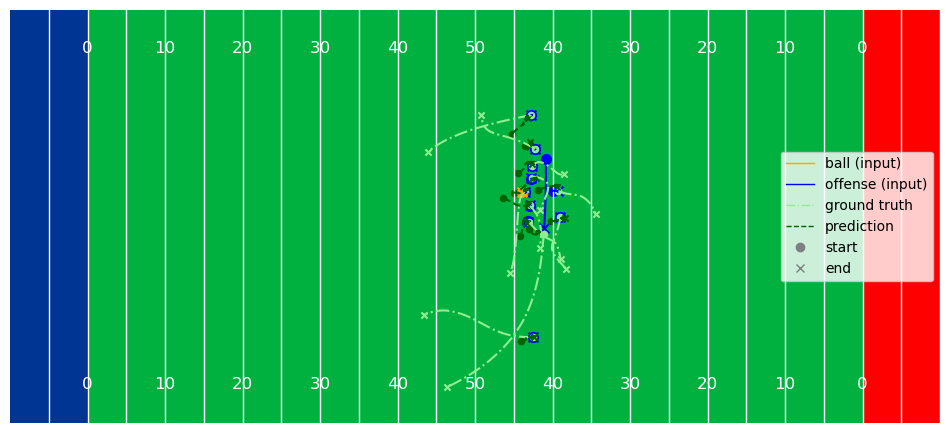

In [11]:
# Filter to test rows and pick one at random
N_STEPS = 40

row = (
    df
    .loc[df['split'] == "test", ['gameId', 'playId']]
    .sample(n=1) 
)

# Extract into Python variables
gameId = row['gameId'].iloc[0]
playId = row['playId'].iloc[0]

print(f"Selected gameId = {gameId}, playId = {playId}")

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_2.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

pred = model.predict(context_seq)

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=gt_future,
        pred_seq=pred,
        offense='all', defense=None, include_ball=True)

In [ ]:
%%time
from tqdm import tqdm

N_STEPS = 40

# Grab only test split ids
ids_in_test = game_indexer.loc[game_indexer['split'] == "test", ['gameId', 'playId']][0:1000]

# Will hold an (n_plays, N_STEPS) array of L2 errors
all_errors = []

# Loop over every play in the test set
for ids_in_test.values:
    # load context + ground truth future
    context_seq, gt_future = load_play(
        parquet_path="../../processed_data/model_input_2.parquet",
        game_id=gameId,
        play_id=playId,
        ctx_len=100,
        n_future=N_STEPS,
    )

    # Skip if sequence is empty
    if context_seq is None or gt_future is None:
        continue
    # Skip if sequence is all zeros
    if np.all(context_seq == 0) or np.all(gt_future == 0):
        continue
    # Skip if gt_future is less than N_STEPS
    if gt_future.shape[1] < N_STEPS:
        continue

    # Calculate length of the sequence to be predicted
    seq_len = gt_future.shape[1]  # (100, 46)
    
    # autoregressive prediction
    pred = model.predict(context_seq)  # (1, 40, 46)
    
    # ground-truth for those same steps
    gt = gt_future[0]                                       # (N_STEPS, 46)
    
    # per-frame Euclidean distance (add small eps for stability)
    dists = np.sqrt(np.sum((pred - gt)**2, axis=-1) + 1e-6)  # (N_STEPS,)
    
    all_errors.append(dists)

all_errors = np.stack(all_errors)  # shape = (n_plays, N_STEPS)

# mean error at each future step
mean_error_per_step = all_errors.mean(axis=0)  # (N_STEPS,)

# overall mean error (averaged across all plays & steps)
overall_mean_error = all_errors.mean()

print(f"\nOverall mean Euclidean error (all plays & steps): {overall_mean_error:.4f}")
print(f"\nMultiplied by 120: {overall_mean_error * 120:.4f}")


Evaluating test plays:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:   0%|          | 3/1000 [00:00<01:30, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:   1%|          | 11/1000 [00:00<00:49, 20.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Evaluating test plays:   2%|▏         | 20/1000 [00:00<00:40, 24.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating test plays:   2%|▏         | 23/1000 [00:01<00:52, 18.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:   3%|▎         | 34/1000 [00:01<00:44, 21.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:   4%|▍         | 45/1000 [00:02<00:43, 22.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:   6%|▌         | 55/1000 [00:02<00:57, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:   8%|▊         | 83/1000 [00:03<00:25, 36.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:   9%|▉         | 89/1000 [00:03<00:29, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:   9%|▉         | 94/1000 [00:04<00:34, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating test plays:  10%|▉         | 98/1000 [00:04<00:41, 21.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  10%|█         | 101/1000 [00:04<00:48, 18.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  11%|█         | 106/1000 [00:04<00:49, 18.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  11%|█▏        | 114/1000 [00:05<00:42, 20.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating test plays:  12%|█▏        | 124/1000 [00:05<00:36, 23.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  14%|█▍        | 138/1000 [00:05<00:29, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  14%|█▍        | 141/1000 [00:06<00:36, 23.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  15%|█▍        | 148/1000 [00:06<00:36, 23.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  16%|█▌        | 157/1000 [00:06<00:33, 25.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating test plays:  17%|█▋        | 166/1000 [00:07<00:32, 25.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  17%|█▋        | 171/1000 [00:07<00:35, 23.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Evaluating test plays:  18%|█▊        | 178/1000 [00:07<00:34, 23.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  20%|█▉        | 197/1000 [00:08<00:30, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:  20%|██        | 203/1000 [00:09<00:39, 20.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  21%|██        | 208/1000 [00:09<00:39, 19.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  21%|██▏       | 213/1000 [00:09<00:40, 19.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  22%|██▏       | 217/1000 [00:10<00:43, 18.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:  22%|██▎       | 225/1000 [00:10<00:45, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating test plays:  23%|██▎       | 234/1000 [00:11<00:43, 17.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  24%|██▍       | 240/1000 [00:11<00:41, 18.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  25%|██▍       | 248/1000 [00:11<00:36, 20.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  25%|██▌       | 251/1000 [00:11<00:41, 17.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Evaluating test plays:  26%|██▌       | 255/1000 [00:12<00:43, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  26%|██▌       | 257/1000 [00:12<00:52, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  26%|██▌       | 262/1000 [00:12<00:48, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  27%|██▋       | 270/1000 [00:13<00:39, 18.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating test plays:  27%|██▋       | 272/1000 [00:13<00:47, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  28%|██▊       | 281/1000 [00:13<00:37, 19.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  28%|██▊       | 283/1000 [00:13<00:45, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  29%|██▊       | 286/1000 [00:14<00:50, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating test plays:  29%|██▉       | 288/1000 [00:14<01:13,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  29%|██▉       | 294/1000 [00:15<01:05, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  30%|███       | 302/1000 [00:15<00:46, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  30%|███       | 305/1000 [00:15<00:49, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  31%|███       | 312/1000 [00:16<00:49, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  32%|███▏      | 319/1000 [00:16<00:47, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Evaluating test plays:  32%|███▏      | 321/1000 [00:17<00:56, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating test plays:  32%|███▎      | 325/1000 [00:17<00:53, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  33%|███▎      | 327/1000 [00:17<01:00, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  33%|███▎      | 329/1000 [00:17<01:06, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating test plays:  33%|███▎      | 331/1000 [00:18<01:12,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  34%|███▍      | 340/1000 [00:18<00:42, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  36%|███▌      | 356/1000 [00:18<00:24, 25.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  36%|███▋      | 363/1000 [00:19<00:25, 24.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating test plays:  37%|███▋      | 370/1000 [00:19<00:26, 23.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  38%|███▊      | 375/1000 [00:19<00:28, 21.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Evaluating test plays:  38%|███▊      | 379/1000 [00:20<00:31, 19.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  38%|███▊      | 384/1000 [00:20<00:32, 19.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  40%|███▉      | 396/1000 [00:20<00:27, 22.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating test plays:  40%|███▉      | 399/1000 [00:21<00:31, 18.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  40%|████      | 402/1000 [00:21<00:36, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  41%|████      | 406/1000 [00:21<00:38, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  41%|████▏     | 413/1000 [00:22<00:48, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  42%|████▏     | 415/1000 [00:22<00:54, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  42%|████▏     | 420/1000 [00:23<00:44, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:  43%|████▎     | 430/1000 [00:23<00:28, 19.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:  45%|████▌     | 453/1000 [00:23<00:13, 40.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  48%|████▊     | 476/1000 [00:24<00:15, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  50%|█████     | 500/1000 [00:24<00:10, 48.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating test plays:  51%|█████     | 508/1000 [00:25<00:16, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Evaluating test plays:  51%|█████▏    | 514/1000 [00:25<00:17, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  52%|█████▏    | 519/1000 [00:26<00:19, 25.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  53%|█████▎    | 527/1000 [00:26<00:18, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  53%|█████▎    | 531/1000 [00:26<00:20, 22.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  53%|█████▎    | 534/1000 [00:26<00:23, 19.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Evaluating test plays:  54%|█████▎    | 537/1000 [00:27<00:27, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  54%|█████▍    | 540/1000 [00:27<00:30, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  54%|█████▍    | 542/1000 [00:27<00:35, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  54%|█████▍    | 544/1000 [00:27<00:41, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  55%|█████▍    | 546/1000 [00:28<00:45,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating test plays:  55%|█████▍    | 548/1000 [00:28<00:49,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  56%|█████▌    | 557/1000 [00:28<00:28, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating test plays:  56%|█████▋    | 563/1000 [00:29<00:25, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  57%|█████▋    | 568/1000 [00:29<00:25, 17.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  58%|█████▊    | 584/1000 [00:30<00:19, 21.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  59%|█████▊    | 587/1000 [00:30<00:23, 17.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  59%|█████▉    | 593/1000 [00:30<00:22, 18.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  60%|██████    | 601/1000 [00:31<00:19, 20.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  60%|██████    | 604/1000 [00:31<00:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating test plays:  62%|██████▏   | 616/1000 [00:31<00:18, 20.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  62%|██████▏   | 619/1000 [00:32<00:20, 18.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  62%|██████▏   | 621/1000 [00:32<00:24, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  63%|██████▎   | 630/1000 [00:33<00:25, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Evaluating test plays:  64%|██████▎   | 635/1000 [00:33<00:24, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  64%|██████▎   | 637/1000 [00:33<00:27, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Evaluating test plays:  65%|██████▍   | 646/1000 [00:34<00:19, 17.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  65%|██████▍   | 648/1000 [00:34<00:23, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  65%|██████▌   | 650/1000 [00:34<00:26, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  65%|██████▌   | 652/1000 [00:35<00:31, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  66%|██████▌   | 659/1000 [00:35<00:22, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Evaluating test plays:  66%|██████▌   | 662/1000 [00:35<00:24, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  66%|██████▋   | 664/1000 [00:35<00:28, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  67%|██████▋   | 666/1000 [00:36<00:31, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  67%|██████▋   | 670/1000 [00:36<00:28, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating test plays:  67%|██████▋   | 672/1000 [00:36<00:32, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  69%|██████▉   | 689/1000 [00:37<00:11, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  69%|██████▉   | 694/1000 [00:37<00:13, 23.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  70%|██████▉   | 698/1000 [00:37<00:14, 20.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  70%|███████   | 702/1000 [00:37<00:16, 18.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  70%|███████   | 705/1000 [00:38<00:18, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  76%|███████▌  | 759/1000 [00:39<00:07, 33.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  76%|███████▋  | 764/1000 [00:40<00:08, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating test plays:  77%|███████▋  | 768/1000 [00:40<00:10, 21.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating test plays:  77%|███████▋  | 771/1000 [00:41<00:18, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating test plays:  78%|███████▊  | 778/1000 [00:41<00:16, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  78%|███████▊  | 783/1000 [00:42<00:18, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  79%|███████▉  | 788/1000 [00:42<00:20, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  81%|████████  | 812/1000 [00:43<00:08, 21.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating test plays:  82%|████████▏ | 822/1000 [00:44<00:07, 22.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating test plays:  82%|████████▎ | 825/1000 [00:44<00:09, 18.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Evaluating test plays:  83%|████████▎ | 827/1000 [00:44<00:11, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  83%|████████▎ | 834/1000 [00:45<00:09, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating test plays:  84%|████████▍ | 844/1000 [00:45<00:07, 20.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  85%|████████▍ | 846/1000 [00:45<00:09, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating test plays:  85%|████████▌ | 850/1000 [00:46<00:10, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating test plays:  86%|████████▌ | 862/1000 [00:46<00:07, 18.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating test plays:  86%|████████▋ | 864/1000 [00:46<00:08, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating test plays:  87%|████████▋ | 871/1000 [00:47<00:07, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating test plays:  88%|████████▊ | 875/1000 [00:47<00:10, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating test plays:  88%|████████▊ | 882/1000 [00:48<00:08, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating test plays:  89%|████████▊ | 886/1000 [00:48<00:08, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays:  89%|████████▉ | 894/1000 [00:49<00:08, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating test plays:  91%|█████████ | 908/1000 [00:49<00:04, 22.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating test plays:  91%|█████████▏| 913/1000 [00:50<00:06, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating test plays:  92%|█████████▏| 917/1000 [00:50<00:06, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating test plays:  93%|█████████▎| 926/1000 [00:51<00:04, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating test plays:  94%|█████████▍| 942/1000 [00:51<00:02, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating test plays:  96%|█████████▌| 959/1000 [00:52<00:01, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating test plays:  98%|█████████▊| 976/1000 [00:53<00:00, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating test plays:  98%|█████████▊| 983/1000 [00:53<00:00, 23.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating test plays: 100%|██████████| 1000/1000 [00:54<00:00, 18.49it/s]


Overall mean Euclidean error (all plays & steps): 0.2006

Multiplied by 120: 24.0774
CPU times: total: 6min 40s
Wall time: 54.1 s
